In [1]:
import pyscf

import numpy as np
import scipy as sp
import pandas as pd

import math
import itertools

# Because we have 6 spatial orbitals and 6 electrons, we have 12 total single-particle states (spin-orbitals) and therefore 12-choose-6 = 924 Slater determinants.
# BUT! We don't actually need every single one of these Slater determinants.
# We only need the ones that are connected by the Hamiltonian, i.e. the ones that have a non-zero matrix element between them.

h1e = np.load("h1e.npy")
h2e = np.load("h2e.npy")

# I need to generate every Slater determinant and also calculate each matrix element.

# Our matrix will be 924 by 924. Twelve choose six.

def determinants(norb, nelec):
    return list(itertools.combinations(range(norb*2), nelec))

H6determinants = determinants(6, 6)

def count_differences(microstate1, microstate2):
    return len(microstate1) - len(list(set(microstate1).intersection(set(microstate2))))

# print(count_differences(H6determinants[0], H6determinants[920]))

def number_of_swaps(microstate1, microstate2, nelec):
    left_terms = []
    left_positions = []
    right_terms = []
    right_positions = []
    for i in range(len(microstate1)):
        if microstate1[i] not in microstate2:
            left_terms.append(microstate1[i])
            left_positions.append(nelec - i - 1)
    for i in range(len(microstate2)):
        if microstate2[i] not in microstate1:
            right_terms.append(microstate2[i])
            right_positions.append(nelec - i - 1)
    swaps = 0 
    for i in range(len(left_terms)):
        swaps += left_positions[i]
        swaps += right_positions[i]

    #return swaps, left_terms, left_positions, right_terms, right_positions
    return swaps

#print(H6determinants[0])
#print(H6determinants[920])

#print(number_of_swaps(H6determinants[0], H6determinants[920], 6))
    
    
def diagonalelement(microstate1,h1e,h2e,norb):
    energy = 0 
    for i in range(len(microstate1)):
        energy += h1e[microstate1[i]%norb, microstate1[i]%norb]

    twoelectronenergy = 0
    for i in range(len(microstate1)):
        for j in range(len(microstate1)):
            #print(h2e[microstate1[i]%norb, microstate1[j]%norb, microstate1[i]%norb, microstate1[j]%norb])
            twoelectronenergy += 0.5 * h2e[microstate1[i]%norb, microstate1[i]%norb, microstate1[j]%norb, microstate1[j]%norb]
            if microstate1[i] < norb and microstate1[j] < norb:
                #print(h2e[microstate1[i]%norb, microstate1[j]%norb, microstate1[j]%norb, microstate1[i]%norb])
                twoelectronenergy -= 0.5 * h2e[microstate1[i]%norb, microstate1[j]%norb, microstate1[j]%norb, microstate1[i]%norb]
            if microstate1[i] >= norb and microstate1[j] >= norb:
                #print(h2e[microstate1[i]%norb, microstate1[j]%norb, microstate1[j]%norb, microstate1[i]%norb])
                twoelectronenergy -= 0.5 * h2e[microstate1[i]%norb, microstate1[j]%norb, microstate1[j]%norb, microstate1[i]%norb]
    energy += twoelectronenergy
    return energy

def oneDifference(microstate1, microstate2, h1e, h2e, norb):
    energy = 0
    twoelectronenergy = 0
    for i in range(len(microstate1)):
        for j in range(len(microstate2)):
            if microstate1[i] not in microstate2 and microstate2[j] not in microstate1:
                if microstate1[i] < norb and microstate2[j] >= norb:
                    return 0
                if microstate1[i] >= norb and microstate2[j] < norb:
                    return 0
                energy += h1e[microstate1[i]%norb, microstate2[j]%norb]
                for k in range(len(microstate1)):
                    if k != i:
                        twoelectronenergy += h2e[microstate1[k]%norb, microstate1[k]%norb, microstate1[i]%norb, microstate2[j]%norb]
                        if microstate1[k] < norb and microstate1[i] < norb:
                            twoelectronenergy -= h2e[microstate1[k]%norb, microstate1[i]%norb, microstate1[k]%norb, microstate2[j]%norb]
                        if microstate1[k] >= norb and microstate1[i] >= norb:
                            twoelectronenergy -= h2e[microstate1[k]%norb, microstate1[i]%norb, microstate1[k]%norb, microstate2[j]%norb]
    energy += twoelectronenergy
    energy *= (-1)**number_of_swaps(microstate1, microstate2, len(microstate1))
    return energy

def twoDifference(microstate1, microstate2, h1e, h2e, norb):
    twoelectronenergy = 0
    microstate1elements = []
    microstate2elements = []
    for i in range(len(microstate1)):
        if microstate1[i] not in microstate2:
            microstate1elements.append(microstate1[i])
    for i in range(len(microstate2)):
        if microstate2[i] not in microstate1:
            microstate2elements.append(microstate2[i])
    
    if microstate1elements[0] < norb and microstate2elements[0] >= norb:
        return 0
    if microstate1elements[0] >= norb and microstate2elements[0] < norb:
        return 0
    if microstate1elements[1] < norb and microstate2elements[1] >= norb:
        return 0
    if microstate2elements[1] < norb and microstate1elements[1] >= norb:
        return 0

    twoelectronenergy += h2e[microstate1elements[0]%norb, microstate2elements[0]%norb, microstate1elements[1]%norb, microstate2elements[1]%norb]
    if microstate1elements[1] < norb and microstate2elements[1] < norb:
        twoelectronenergy -= h2e[microstate1elements[0]%norb, microstate2elements[1]%norb, microstate1elements[1]%norb, microstate2elements[0]%norb]
    if microstate1elements[0] >= norb and microstate2elements[0] >= norb:
        twoelectronenergy -= h2e[microstate1elements[0]%norb, microstate2elements[1]%norb, microstate1elements[1]%norb, microstate2elements[0]%norb]


    twoelectronenergy *= (-1)**number_of_swaps(microstate1, microstate2, len(microstate1))
    return twoelectronenergy
  

def combinations(norb, nelec):
    return list(itertools.combinations(range(norb*2), nelec))

def fci_matrix(h1e, h2e, norb, nelec):
    determinants = combinations(norb, nelec)
    matrix = np.zeros((len(determinants), len(determinants)))
    for i in range(len(determinants)):
        for j in range(len(determinants)):
            if count_differences(determinants[i], determinants[j]) == 0:
                matrix[i,j] = diagonalelement(determinants[i], h1e, h2e, norb)
            if count_differences(determinants[i], determinants[j]) == 1:
                matrix[i,j] = oneDifference(determinants[i], determinants[j], h1e, h2e, norb)
            if count_differences(determinants[i], determinants[j]) == 2:
                matrix[i,j] = twoDifference(determinants[i], determinants[j], h1e, h2e, norb)
    return matrix

#print(fci_matrix(h1e, h2e, 6, 6))

eigvals, eigvecs = np.linalg.eigh(fci_matrix(h1e, h2e, 6, 6))
#print(eigvals)

#print(min(eigvals))





In [ ]:
# (0, 1, 2, 3, 4, 5) --> (1, 2, 3, 4, 5, 0), five swaps
# (1, 2, 3, 4, 5, 0) --> (2, 3, 4, 5, 1, 0), four swaps
# (2, 3, 4, 5, 1, 0) --> (3, 4, 5, 2, 1, 0), three swaps
# (3, 4, 5, 2, 1, 0) --> (4, 5, 3, 2, 1, 0), two swaps
# (4, 5, 3, 2, 1, 0) --> (5, 4, 3, 2, 1, 0), one swap

# (5, 6, 7, 9, 10, 11) --> (5, 7, 9, 10, 11, 6), four swaps
# (5, 7, 9, 10, 11, 6) --> (5, 9, 10, 11, 7, 6), three swaps
# (5, 9, 10, 11, 7, 6) --> (5, 10, 11, 9, 7, 6), two swaps
# (5, 10, 11, 9, 7, 6) --> (5, 11, 10, 9, 7, 6), one swap


In [ ]:
(0, 1, 2, 3, 4, 5)
(5, 6, 7, 9, 10, 11)
(53, [0, 1, 2, 3, 4], [5, 4, 3, 2, 1], [6, 7, 9, 10, 11], [4, 3, 2, 1, 0])

In [2]:
# Davidson algorithm implementation
# take in a matrix and return the lowest eigenvalue and eigenvector

# Here we perform the crude Davidson without the Jacobi correction method.

import numpy as np

def manual_davidson(matrix):
    dimension = len(matrix)
    guessV = np.zeros(dimension)
    for i in range(dimension):
        guessV[i] = np.random.rand()
    guessV /= np.linalg.norm(guessV)
    guessV = np.reshape(guessV, (dimension, 1))
    #print(guessV)

    guessV = np.zeros(dimension)
    guessV[0] = 1
    
    guessV = np.reshape(guessV, (dimension, 1))
    

    projection = np.dot(guessV.T, np.dot(matrix, guessV))
    #print(projection)
    # cannot diagonalize as this is just 1x1
    # Now we want to compute the residue vector
    r = np.dot(matrix, guessV) - projection * guessV
    print(r)
    q = -r.T / (np.diag(matrix) - projection + 1E-18)
    q /= np.linalg.norm(q)
    print(q.T)
    q = np.reshape(q, (dimension, 1))
    print(q)
    print(np.dot(q.T,guessV))

    newV = np.hstack((guessV,q))
    print(newV)
    newVorth = np.linalg.qr(newV)[0]
    print(newVorth)

    proj2 = np.dot(newVorth.T, np.dot(matrix, newVorth))
    theta,s = np.linalg.eigh(proj2)
    print(theta)
    r2 = np.dot((np.dot(A,newVorth)-theta[0]*newVorth),s[:,0])
    print(r2)
    print(np.linalg.norm(r2))

    return theta[0], np.dot(newVorth,s[:,0])


A = 0.1*np.ones((5,5)) + np.diag([0.9,1.9,2.9,2.9,2.9])

#manual_davidson(A)



In [3]:
def rudimentaryDavidson(matrix):

    # create a guess matrix
    dimension = len(matrix)
    guessV1 = np.zeros(dimension)
    guessV2 = np.zeros(dimension)
    for i in range(dimension):
        guessV1[i] = np.random.rand()
        guessV2[i] = np.random.rand()
    guessV1 /= np.linalg.norm(guessV1)
    guessV2 /= np.linalg.norm(guessV2)
    # Gram-Schmidt orthogonalization
    guessV2 -= np.dot(guessV2.T, guessV1) * guessV1
    guessV2 /= np.linalg.norm(guessV2)
    guessV1 = np.reshape(guessV1, (dimension, 1))
    guessV2 = np.reshape(guessV2, (dimension, 1))
    Vectors = np.hstack((guessV1, guessV2))
    norm = 1

    eigenvector = []
    eigenvalue = 0

    while norm > 0.0001:
        # project the FCI matrix onto the guess basis
        projection = np.dot(Vectors.T, np.dot(matrix, Vectors))
        # diagonalize the projection
        theta, s = np.linalg.eigh(projection)
        # compute the residue vector
        r = np.dot((np.dot(matrix,Vectors)-theta[0]*Vectors),s[:,0])
        # diagonal preconditioning
        q = -r.T / (np.diag(matrix) - theta[0] + 1E-18)
        q /= np.linalg.norm(q)
        q = np.reshape(q, (dimension, 1))
        eigenvector = np.dot(Vectors, s[:,0])
        eigenvalue = theta[0]

        Vectors = np.hstack((Vectors, q))
        # QR to orthogonalize
        Vectors = np.linalg.qr(Vectors)[0]

        norm = np.linalg.norm(r)
        
    return eigenvector, eigenvalue

A = np.zeros((200,200))
np.fill_diagonal(A, np.random.random(200))
A += np.ones((200,200))*0.1
#print(rudimentaryDavidson(A)[1])

eigvals, eigvecs = np.linalg.eigh(A)
#print(min(eigvals))




In [4]:
print(rudimentaryDavidson(fci_matrix(h1e, h2e, 6, 6)))

(array([-1.88934755e-08,  4.06244018e-08, -1.40348514e-07,  1.19486645e-07,
       -8.45959738e-09,  6.32279223e-08,  4.06893779e-09,  1.22525969e-08,
       -2.55892877e-08,  4.51602402e-08,  8.20703180e-10,  2.04154361e-08,
       -6.23997318e-08, -5.50097974e-06,  2.14005427e-06, -2.12674518e-07,
        2.09931982e-07, -2.48884024e-07,  7.05939058e-07, -4.51741246e-07,
        3.80659677e-07, -4.20953300e-08, -5.14658935e-07,  7.30357701e-08,
       -1.59149356e-08,  1.72251899e-07,  8.60274091e-09,  1.02855430e-07,
       -1.32211664e-07,  1.66212858e-08,  3.70143940e-09,  4.22910415e-08,
       -7.47393732e-08, -3.75665554e-08,  9.49439591e-07, -1.21465234e-07,
       -6.97954841e-09, -7.00615164e-07,  6.63067829e-08,  1.99279555e-07,
        1.15310044e-06, -1.39792131e-07, -1.85990749e-07, -4.02081595e-08,
       -3.74462000e-07, -7.44643932e-08, -1.05394892e-07, -2.81804860e-07,
        7.75277587e-08,  4.28814159e-07, -9.44222688e-08,  7.56117756e-08,
        1.58109629e-08, 

In [22]:
import numpy as np
import scipy as sp
import pandas as pd
import pyscf
import math
import itertools

M = 6
N = 3

def addressing_array(k, l):
    # M is the number of orbitals
    # N is the number of electrons
    # k is an orbital
    # l is an electron

    # a string is identified by a list of occupied orbitals in ascending order

    result = 0

    if k < N and l >= k:
        for m in range(M - l + 1, M - k + 1):
            result += math.comb(m, N - k)
            result -= math.comb(m - 1, N - k -1)
    elif k == N:
        result = l - N    
    return result

def address(detstring):
    address_value = 1
    for i in range(len(detstring)):
        address_value += addressing_array(i+1, detstring[i])
    return address_value

detlist = []
for thing in itertools.combinations(range(1, 7), 3):
    thisdet = []
    for i in range(N):
        thisdet.append(thing[i])
    print(thisdet, address(thisdet))
    detlist.append(thisdet)

#print(detlist)
#print(len(detlist))

[1, 2, 3] 1
[1, 2, 4] 2
[1, 2, 5] 3
[1, 2, 6] 4
[1, 3, 4] 5
[1, 3, 5] 6
[1, 3, 6] 7
[1, 4, 5] 8
[1, 4, 6] 9
[1, 5, 6] 10
[2, 3, 4] 11
[2, 3, 5] 12
[2, 3, 6] 13
[2, 4, 5] 14
[2, 4, 6] 15
[2, 5, 6] 16
[3, 4, 5] 17
[3, 4, 6] 18
[3, 5, 6] 19
[4, 5, 6] 20


In [7]:
def number_of_swaps(microstate1, microstate2, nelec):
    left_terms = []
    left_positions = []
    right_terms = []
    right_positions = []
    for i in range(len(microstate1)):
        if microstate1[i] not in microstate2:
            left_terms.append(microstate1[i])
            left_positions.append(nelec - i - 1)
    for i in range(len(microstate2)):
        if microstate2[i] not in microstate1:
            right_terms.append(microstate2[i])
            right_positions.append(nelec - i - 1)
    swaps = 0 
    for i in range(len(left_terms)):
        swaps += left_positions[i]
        swaps += right_positions[i]

    #return swaps, left_terms, left_positions, right_terms, right_positions
    return swaps

# What was my logic in creating this???
# We want to move the differences to the end, noting that our determinants are ordered already in increasing order. So we only need to 
# identify those terms that differ and move them to the end.
# We need to count the number of swaps needed to move the differences to the end.

In [21]:
#print(number_of_swaps([1, 2, 4], [1, 4, 6], 3))

In [9]:
M = 6
N = 3

def createdetlist(number_of_orbitals, number_of_electrons):
    determinantlist = []
    for thing in itertools.combinations(range(1, number_of_orbitals+1), number_of_electrons):
        thisdet = []
        for i in range(number_of_electrons):
            thisdet.append(thing[i])
        determinantlist.append(thisdet)
    return determinantlist

detlist = []
for thing in itertools.combinations(range(1, 7), 3):
    det = []
    for i in range(N):
        det.append(thing[i])
        #print(det, address(det))
    detlist.append(det)

def smallsinglereplacementmatrix(adetlist):
    matrix = np.zeros((len(adetlist), len(adetlist)))
    for i in range(len(adetlist)):
        for j in range(len(adetlist)):
            if count_differences(adetlist[i], adetlist[j]) == 0:
                matrix[i,j] += 1
            if count_differences(adetlist[i], adetlist[j]) == 1:
                matrix[i,j] += (-1)**(number_of_swaps(adetlist[i], adetlist[j], N))
    return matrix
        

In [20]:
#print(smallsinglereplacementmatrix(detlist))

In [11]:
def alphabetaaddresses(adetlist):
    # We want to see how many electrons we have. Assuming singlet.
    nalpha = len(adetlist[0])
    nbeta = nalpha
    greatmatrix = []

    for i in range(len(adetlist)):
        thisrow = []
        for j in range(len(adetlist)):
            thiselement = []
            thiselement.append(adetlist[i])
            thiselement.append(adetlist[j])
            thisrow.append(thiselement)
        greatmatrix.append(thisrow)
    
    return greatmatrix   

In [12]:
element12 = alphabetaaddresses(detlist)[18][19]
print(address(element12[0]), address(element12[1]))
print(np.shape(alphabetaaddresses(detlist)))

19 20
(20, 20, 2, 3)


In [13]:
def equivalent_orbitals(microstate1, microstate2):
    for i in range(len(microstate1)):
        if microstate1[i] != microstate2[i]:
            return False
    return True

def greatsinglereplacementmatrix(adetlist):
    elementmatrix = alphabetaaddresses(adetlist)
    reshapeelements = np.reshape(elementmatrix, (len(adetlist)**2, 2, 3))
   
    #print(reshapeelements)
    #print(len(reshapeelements))
    replacementmatrix = np.zeros((len(adetlist)**2,len(adetlist)**2))

    for i in range(len(reshapeelements)):
        for j in range(len(reshapeelements)):
            elementi = reshapeelements[i]
            elementj = reshapeelements[j]
            if equivalent_orbitals(elementi[0],elementj[0]):
                differences = count_differences(elementi[1], elementj[1])
                if differences == 0:
                    replacementmatrix[i,j] += 1
                if differences == 1:
                    replacementmatrix[i,j] += (-1)**number_of_swaps(elementi[1], elementj[1], 3)
            elif equivalent_orbitals(elementi[1],elementj[1]):
                differences = count_differences(elementi[0], elementj[0])
                if differences == 0:
                    replacementmatrix[i,j] += 1
                if differences == 1:
                    replacementmatrix[i,j] += (-1)**number_of_swaps(elementi[0], elementj[0], 3)

    return replacementmatrix

print(greatsinglereplacementmatrix(detlist))

[[ 1.  1.  1. ...  0.  0.  0.]
 [ 1.  1.  1. ...  0.  0.  0.]
 [ 1.  1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  1. -1.]
 [ 0.  0.  0. ...  1.  1.  1.]
 [ 0.  0.  0. ... -1.  1.  1.]]


In [30]:
def addressingmatrix(adetlist):
    elementmatrix = alphabetaaddresses(adetlist)
    reshapeelements = np.reshape(elementmatrix, (len(adetlist)**2, 2, 3))
    return reshapeelements

referencematrix = addressingmatrix(detlist)
#print(referencematrix)

[[[1 2 3]
  [1 2 3]]

 [[1 2 3]
  [1 2 4]]

 [[1 2 3]
  [1 2 5]]

 ...

 [[4 5 6]
  [3 4 6]]

 [[4 5 6]
  [3 5 6]]

 [[4 5 6]
  [4 5 6]]]


In [18]:
my400by400 = greatsinglereplacementmatrix(detlist)

somevector = np.zeros(400)
somevector[69] = 1
action = np.dot(my400by400,somevector)

#print(action)

print(referencematrix[69])
for i in range(len(action)):
    if action[i] != 0:
        print(action[i], " ", referencematrix[i], "\n")

# Single replacements correctly generated.


[[1 2 6]
 [1 5 6]]
1.0   [[1 2 3]
 [1 5 6]] 

1.0   [[1 2 4]
 [1 5 6]] 

1.0   [[1 2 5]
 [1 5 6]] 

-1.0   [[1 2 6]
 [1 2 5]] 

1.0   [[1 2 6]
 [1 2 6]] 

-1.0   [[1 2 6]
 [1 3 5]] 

1.0   [[1 2 6]
 [1 3 6]] 

-1.0   [[1 2 6]
 [1 4 5]] 

1.0   [[1 2 6]
 [1 4 6]] 

1.0   [[1 2 6]
 [1 5 6]] 

1.0   [[1 2 6]
 [2 5 6]] 

1.0   [[1 2 6]
 [3 5 6]] 

1.0   [[1 2 6]
 [4 5 6]] 

1.0   [[1 3 6]
 [1 5 6]] 

1.0   [[1 4 6]
 [1 5 6]] 

1.0   [[1 5 6]
 [1 5 6]] 

-1.0   [[2 3 6]
 [1 5 6]] 

-1.0   [[2 4 6]
 [1 5 6]] 

-1.0   [[2 5 6]
 [1 5 6]] 



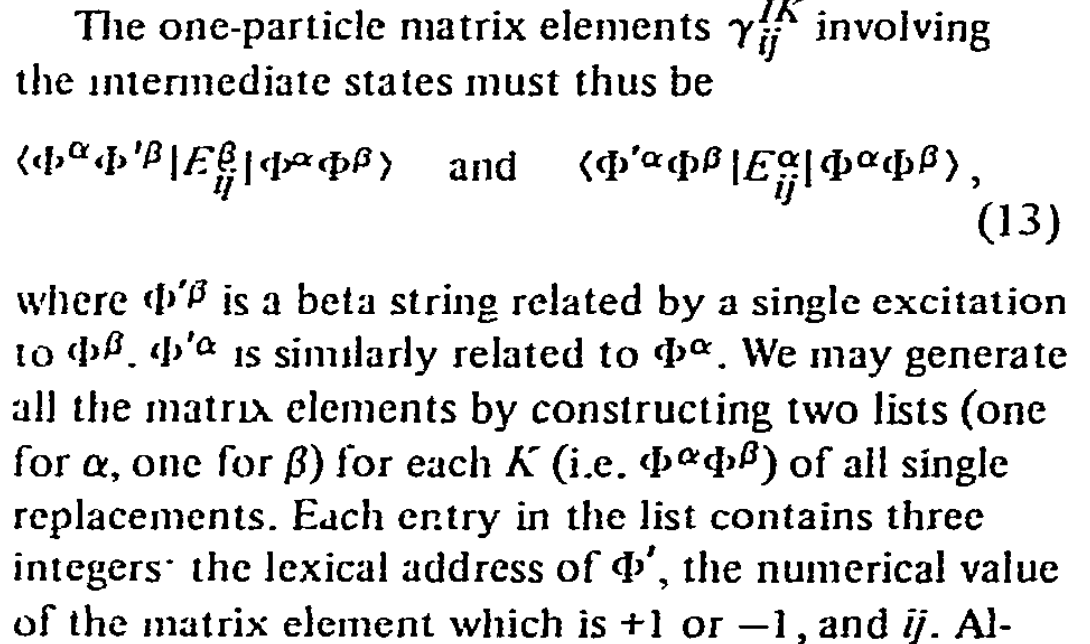


In [ ]:
# I need to make a list of single replacements.
def singlyreplacealpha(alphabetadeterminant):
    alphadet = alphabetadeterminant[0]
    betadet = alphabetadeterminant[1]

    

In [24]:
h2e = np.load("h2e.npy")
print(np.shape(h2e))

(6, 6, 6, 6)


In [25]:
dmatrix = np.zeros((400,400))